In [30]:
from verispy import VERIS

In [31]:
data_dir = 'C:/bharath/project/VCDB-master/data/json/validated'
v = VERIS(json_dir=data_dir)

Found 8331 json files.


In [32]:
v.schema_url

'https://raw.githubusercontent.com/vz-risk/veris/master/verisc-merged.json'

In [33]:
df_veris = v.json_to_df(verbose=True)

Loading schema
Loading JSON files to DataFrame.


100%|█████████████████████████████████████████████████████████████████████████████| 8331/8331 [01:03<00:00, 130.26it/s]


Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:24<00:00,  6.97it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame


In [34]:
df_veris.shape

(8331, 2346)

In [35]:
v.enum_summary(df_veris, 'action.social.vector')

,enum,x,n,freq
0,Email,400,500.0,0.800
1,In-person,52,500.0,0.104
2,Phone,18,500.0,0.036
3,Documents,15,500.0,0.030
4,SMS,12,500.0,0.024
5,Software,12,500.0,0.024
6,Website,6,500.0,0.012
7,Social media,4,500.0,0.008
8,Other,3,500.0,0.006
9,IM,1,500.0,0.002


C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


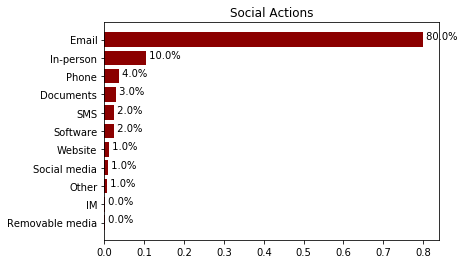

In [36]:
actionci_df = v.enum_summary(df_veris, 'action.social.vector')
action_fig = v.plot_barchart(actionci_df, 'Social Actions')
action_fig.show()

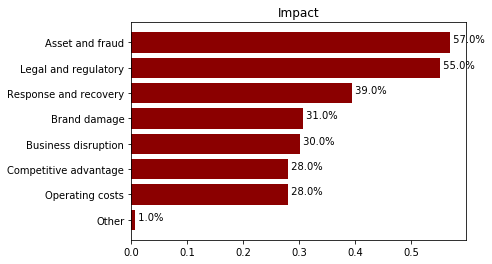

In [37]:
import matplotlib
impactci_df = v.enum_summary(df_veris, 'impact.loss.variety')
impact_fig = v.plot_barchart(impactci_df, 'Impact')
impact_fig.savefig('demo.jpeg', bbox_inches='tight')

In [38]:
import pandas as pd



def get_pattern(df):

    """ Generates the DBIR "patterns," with liberal inspiration from the getpatternlist.R: 

    https://gist.github.com/jayjacobs/a145cb87551f551fc719



    Parameters

    ----------

    df: pd DataFrame with most VERIS encodings already built (from verispy package).



    Returns

    -------

    pd DataFrame with the patterns. Does not return as part of original VERIS DF.

    """

    skimmer = df['action.physical.variety.Skimmer'] | (df['action.physical.variety.Tampering'] & df['attribute.confidentiality.data.variety.Payment'])

    

    espionage = df['actor.external.motive.Espionage'] | df['actor.external.variety.State-affiliated']



    pos = df['asset.assets.variety.S - POS controller'] | df['asset.assets.variety.U - POS terminal']



    dos = df['action.hacking.variety.DoS']



    webapp = df['action.hacking.vector.Web application']

    webapp = webapp & ~(webapp & dos)



    misuse = df['action.Misuse']



    vfilter = skimmer | espionage | pos | dos | webapp | misuse



    mal_tmp = df['action.Malware'] & ~df['action.malware.vector.Direct install']

    malware = mal_tmp & ~vfilter



    theftloss = df['action.error.variety.Loss'] | df['action.physical.variety.Theft']



    vfilter = vfilter | malware | theftloss



    errors = df['action.Error'] & ~vfilter



    vfilter = vfilter | errors



    other = ~vfilter



    patterns = pd.DataFrame({

        'Point of Sale' : pos, 

        'Web Applications' : webapp,

        'Privilege Misuse' : misuse,

        'Lost and Stolen Assets' : theftloss,

        'Miscellaneous Errors' : errors,

        'Crimeware' : malware, 

        'Payment Card Skimmers' : skimmer,

        'Denial of Service' : dos, 

        'Cyber-Espionage' : espionage, 

        'Everything Else' : other

        })



    # reduce names to single label (first one encountered)

    patterns_copy = patterns.copy()

    for col in patterns_copy.columns:

        patterns_copy[col] = patterns_copy[col].apply(lambda x: col if x else '')

    patterns_copy['pattern'] = patterns_copy.apply(lambda x: ','.join(x), axis = 1)

    def get_first(pats):

        pats = [pat for pat in pats.split(',') if len(pat) > 0]

        return pats[0]

    patterns_copy['pattern'] = patterns_copy['pattern'].apply(lambda x: get_first(x))



    # add 'pattern.' to the column names

    patterns.rename(columns = {col : ''.join(('pattern.', col)) for col in patterns.columns}, inplace=True)

    patterns['pattern'] = patterns_copy['pattern']



    return patterns

In [39]:
patterns = get_pattern(df_veris)

In [40]:
patterns['pattern'].value_counts()

Miscellaneous Errors      1949
Privilege Misuse          1692
Lost and Stolen Assets    1487
Everything Else           1104
Web Applications           966
Crimeware                  313
Payment Card Skimmers      309
Cyber-Espionage            252
Denial of Service          163
Point of Sale               96
Name: pattern, dtype: int64

In [41]:
matv = v.df_to_matrix(df_veris)

In [42]:
matv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
matv.shape

(8331, 576)

In [44]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
v_tsne = tsne.fit_transform(matv)

In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [46]:
tsne_df = pd.DataFrame({'x':v_tsne[:, 0], 'y':v_tsne[:, 1], 'pattern':patterns['pattern']})

In [47]:
tsne_df.head()

,x,y,pattern
0,-45.382885,-31.537569,Privilege Misuse
1,44.759933,37.902908,Lost and Stolen Assets
2,42.437054,-7.362857,Lost and Stolen Assets
3,-43.520805,38.791122,Web Applications
4,-10.544584,-72.984276,Miscellaneous Errors


In [48]:
tsne_centers = tsne_df.groupby(by='pattern').mean()
tsne_centers['pattern'] = tsne_centers.index

C:\Users\bhara\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

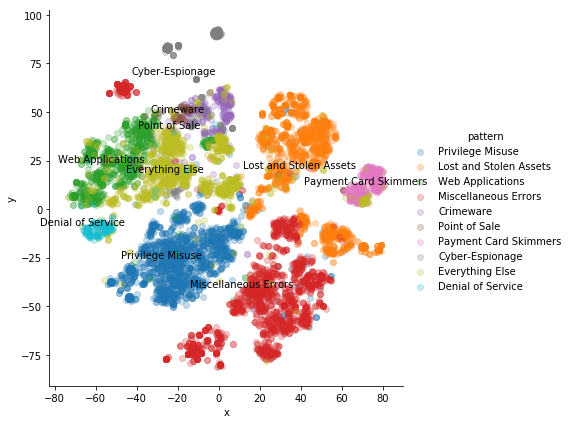

In [49]:
p1 = sns.lmplot(x='x', y='y', data=tsne_df, fit_reg=False, hue='pattern', scatter_kws={'alpha':0.25}, size=6)
def label_point(df, ax):
     for i, point in df.iterrows():
         ax.text(point['x'] - 30, point['y'], point['pattern'])
label_point(tsne_centers, plt.gca())
plt.save('demo1.jpeg',bbox_inches='tight')